# IMPORTS

In [21]:
!pip install optree


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [22]:
import os
import json
import sys
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

import math
from tensorflow.keras import backend as K

In [23]:
tf.__version__

'2.15.0'

In [24]:
try:
    # Attempt to connect to a TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Automatically detects the TPU
    print('Device:', tpu.master())  # Display the TPU address
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)  # Updated to use the non-experimental version
    DEVICE = "TPU"
    print("Running on TPU:", tpu.master())
except ValueError as e:
    # If a TPU is not found, fall back to default strategy (could be CPUs, one GPU or multiple GPUs)
    print("TPU not found, falling back to default strategy (CPU/GPU)")
    print("Error:", e)
    DEVICE = "notTPU"
    strategy = tf.distribute.get_strategy()  # Get the default distribution strategy
    print("Default strategy type:", type(strategy).__name__)

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Running on TPU: 


In [25]:
REPLICAS =  strategy.num_replicas_in_sync
LR = 1e-6 * REPLICAS
EPOCHS = 5

print("Device:" + str(DEVICE))
print("Replicas:" + str(REPLICAS))

Device:TPU
Replicas:8


In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [456, 456]
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 5

In [27]:
train_dir = "/kaggle/input/cassava-leaf-disease-classification/train_images/"
label_dir = "/kaggle/input/cassava-leaf-disease-classification/train.csv"
idx_to_str_dir = "/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json"
# List of TFRecord files
tfrecord_files = ["/kaggle/input/tf-records/tf_records/Id_train00-2140.tfrec",
                  "/kaggle/input/tf-records/tf_records/Id_train01-2140.tfrec",
                  "/kaggle/input/tf-records/tf_records/Id_train02-2140.tfrec",
                  "/kaggle/input/tf-records/tf_records/Id_train03-2140.tfrec",
                  "/kaggle/input/tf-records/tf_records/Id_train04-2140.tfrec",
                  "/kaggle/input/tf-records/tf_records/Id_train05-2140.tfrec",
                  "/kaggle/input/tf-records/tf_records/Id_train06-2140.tfrec",
                  "/kaggle/input/tf-records/tf_records/Id_train07-2139.tfrec",
                  "/kaggle/input/tf-records/tf_records/Id_train08-2139.tfrec",
                  "/kaggle/input/tf-records/tf_records/Id_train09-2139.tfrec",]
                  

# # Create a TFRecordDataset
# dataset = tf.data.TFRecordDataset(tfrecord_files)

In [28]:
def _parse_function(proto):
    # Define the feature description dictionary
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64),
        'image_name': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(proto, features)
    image = tf.image.decode_jpeg(parsed_features['image'], channels=3)
    image = tf.image.resize(image, [456, 456])  # EfficientNet B5 expects this input size
    label = tf.cast(parsed_features['target'], tf.int32)
    label = tf.one_hot(label, depth=5)  # One-hot encode the label
    return image, label


def preprocess(image, label):
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

def load_dataset(filenames, augment_data=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
    if augment_data:  # Avoid naming conflicts by changing the argument name
        dataset = dataset.map(augment, num_parallel_calls= AUTOTUNE)
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

# Function to read and print the first example of a TFRecord file
def read_tfrecord_example(filename):
    raw_dataset = tf.data.TFRecordDataset(filename)
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print(example)

# Apply this function to one of your TFRecord files
# read_tfrecord_example("/kaggle/input/tf-records/tf_records/Id_train00-2140.tfrec")

In [29]:
dataset = load_dataset(tfrecord_files, augment_data=True) 
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 456, 456, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [30]:
# parsed_dataset = dataset.map(parse_tfrecord_fn)
# parsed_dataset



def split_dataset(dataset, train_split=0.8):
    # Determine the number of batches needed for the split
    dataset_size = sum(1 for _ in dataset)
    train_size = int(train_split * dataset_size)
    val_size = dataset_size - train_size

    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=dataset_size)

    # Split the dataset
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    return train_dataset, val_dataset

def prepare_for_training(dataset, batch_size=32):
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [31]:
# train_dataset, val_dataset = split_dataset(dataset, train_split=0.8)
# train_dataset = prepare_for_training(train_dataset, batch_size=BATCH_SIZE)
# val_dataset = prepare_for_training(val_dataset, batch_size=BATCH_SIZE)

In [32]:
import matplotlib.pyplot as plt

# def show_batch(dataset, num_images=5):
#     # Take one batch from the dataset
#     for images, labels in dataset.take(1):
#         plt.figure(figsize=(10, 10))
#         for i in range(num_images):
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(images[i].numpy().astype("uint8"))
#             plt.title(int(labels[i]))
#             plt.axis("off")
#         plt.show()

# # Assuming 'dataset' is already loaded and preprocessed
# show_batch(dataset)

In [33]:
# Function to visualize the dataset
def display_dataset(dataset, rows=3, cols=4):
    plt.figure(figsize=(15, int(15*rows/cols)))
    for images, labels in dataset.take(1):  # Take 1 batch from the dataset
        for i in range(rows*cols):
            plt.subplot(rows, cols, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
        plt.show()

In [34]:
# rows = 3
# cols = 4
# dataset = dataset.unbatch().batch(rows*cols)

# # Display images with augmentations
# print("Displaying Image with Augmentations")
# display_dataset(dataset, rows, cols)

# HELPER FUNCTIONS

Data Augmentation Code

In [35]:
# with strategy.scope():
#     base_model = EfficientNetB5(include_top=False, weights='imagenet', input_shape=(456, 456, 3))
#     base_model.trainable = False  # Start by freezing the base model

#     model = Sequential([
#         base_model,
#         GlobalAveragePooling2D(),
#         Dense(1024, activation='relu'),
#         Dense(len(label_map), activation='softmax')
#     ])

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy')
#     early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')

#     # Adjust batch size according to the number of TPU cores
#     batch_size = 16 * strategy.num_replicas_in_sync

#     # Assume train_dataset and validation_dataset are correctly batched and prefetched
#     history = model.fit(
#         train_dataset,
#         epochs=5,
#         validation_data=validation_dataset,
#         verbose=1,
#         callbacks=[checkpoint_cb, early_stopping_cb]
#     )

#     base_model.trainable = True
#     model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

#     history_fine = model.fit(
#         train_dataset,
#         epochs=5,
#         validation_data=validation_dataset,
#         verbose=1,
#         callbacks=[checkpoint_cb, early_stopping_cb]
#     )

In [43]:
with strategy.scope():  
    initial_learning_rate = 1e-6
    warmup_epochs = 5
    total_epochs = 20
    steps_per_epoch = REPLICAS * (15000 // BATCH_SIZE)

    # Define the learning rate schedule with warm-up
    class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __init__(self, initial_learning_rate, warmup_steps, base_schedule):
            super(WarmUp, self).__init__()
            self.initial_learning_rate = initial_learning_rate
            self.warmup_steps = warmup_steps
            self.base_schedule = base_schedule

        def __call__(self, step):
            warmup_rate = step / self.warmup_steps
            warmup_lr = self.initial_learning_rate * warmup_rate
            return tf.cond(step < self.warmup_steps, lambda: warmup_lr, lambda: self.base_schedule(step - self.warmup_steps))

    # Base learning rate schedule (post-warmup)
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=(total_epochs - warmup_epochs) * steps_per_epoch,
        alpha=0.0
    )

    warmup_steps = warmup_epochs * steps_per_epoch
    learning_rate_schedule = WarmUp(initial_learning_rate, warmup_steps, lr_schedule)

    # Generate learning rate for each step
    steps = list(range(total_epochs * steps_per_epoch))
    learning_rates = [learning_rate_schedule(step) for step in steps]  # Note the .numpy() to extract values

    # Convert steps to epochs
    epochs = [step / steps_per_epoch for step in steps]


#     # Apply the warm-up schedule
#     total_steps = total_epochs * steps_per_epoch
#     warmup_steps = warmup_epochs * steps_per_epoch
#     learning_rate = WarmUp(initial_learning_rate, warmup_steps)

#     # Example of applying this to an optimizer
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

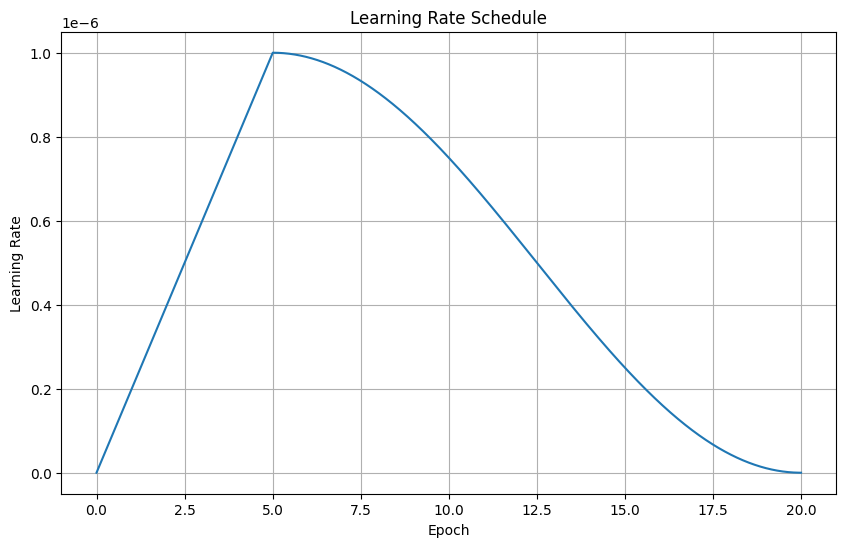

In [44]:
#     # Plotting the learning rate
#     plt.figure(figsize=(10, 6))
#     plt.plot(steps, learning_rates)
#     plt.title('Learning Rate Schedule')
#     plt.xlabel('Training Steps')
#     plt.ylabel('Learning Rate')
#     plt.grid(True)
#     plt.show()      
    # Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, learning_rates)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [38]:
# def decode_image(image_data):
#     image = tf.image.decode_jpeg(image_data, channels=3)
#     image = tf.cast(image, tf.float32) / 255.0
                      
#     image = tf.image.resize(image, [HEIGHT, WIDTH])
#     image = tf.reshape(image, [HEIGHT, WIDTH, 3])
#     return image

# def read_tfrecord(example):
#     TFREC_FORMAT = {
#         'image': tf.io.FixedLenFeature([], tf.string), 
#         'target': tf.io.FixedLenFeature([], tf.int64), 
#         'image_name': tf.io.FixedLenFeature([], tf.string), 
#     }
#     example = tf.io.parse_single_example(example, TFREC_FORMAT)
#     image = decode_image(example['image'])
#     target = example['target']
#     name = example['image_name']
#     return image, target, name

# def load_dataset2(filenames, HEIGHT, WIDTH, CHANNELS=3):
#     dataset = tf.data.TFRecordDataset(filenames)
#     dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
#     return dataset

# def display_samples(ds, row, col):
#     ds_iter = iter(ds)
#     plt.figure(figsize=(15, int(15*row/col)))
#     for j in range(row*col):
#         image, label, name = next(ds_iter)
#         plt.subplot(row,col,j+1)
#         plt.axis('off')
#         plt.imshow(image[0])
#         plt.title(f"{label[0]}: {name[0].numpy().decode('utf-8')}", fontsize=12)
#     plt.show()

# def count_data_items(filenames):
#     n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
#     return np.sum(n)


In [45]:
# Load the mapping from numeric labels to disease names
with open(idx_to_str_dir) as file:
    label_map = json.load(file)

In [46]:
with strategy.scope():
    # Initialize the base model with pretrained weights and without the top layer
    base_model = EfficientNetB5(include_top=False, weights='imagenet', input_shape=(456, 456, 3))
    base_model.trainable = False  # Freeze the base model initially

    # Construct the full model by appending custom layers on top
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dense(len(label_map), activation='softmax')  # Assuming label_map is a dictionary of labels
    ])

    # Compile the model with initial settings
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Setup callbacks
    checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy')
    early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')

    # Prepare the dataset for training and validation
    train_dataset = load_dataset(tfrecord_files[:-2], augment_data=True)  # Last two files for validation
    valid_dataset = load_dataset(tfrecord_files[-2:], augment_data=False)

    # Initial training (transfer learning)
    history = model.fit(
        train_dataset,
        epochs=5,
        validation_data=valid_dataset,
        verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb]
    )

    # Unfreeze the base model for fine-tuning
    base_model.trainable = True

    # Re-compile the model with a lower learning rate for fine-tuning
    model.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])

    # Fine-tuning the model
    history_fine = model.fit(
        train_dataset,
        epochs=100,
        validation_data=valid_dataset,
        verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb]  # Reuse the same callbacks
    )

Epoch 1/5


2024-04-14 00:00:38.829286: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


    134/Unknown 99s 398ms/step - accuracy: 5.0463 - loss: nan   

2024-04-14 00:01:59.003488: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


134/134 ━━━━━━━━━━━━━━━━━━━━ 139s 700ms/step - accuracy: 5.0139 - loss: nan - val_accuracy: 0.7408 - val_loss: 0.7174
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 68s 495ms/step - accuracy: 5.6942 - loss: nan - val_accuracy: 0.7335 - val_loss: 0.7317
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 73s 534ms/step - accuracy: 5.8025 - loss: nan - val_accuracy: 0.7445 - val_loss: 0.6991
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 74s 539ms/step - accuracy: 5.8766 - loss: nan - val_accuracy: 0.7518 - val_loss: 0.6589
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 69s 504ms/step - accuracy: 5.9514 - loss: nan - val_accuracy: 0.7298 - val_loss: 0.7583
Epoch 1/100


2024-04-14 00:10:32.782974: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


    134/Unknown 387s 764ms/step - accuracy: 4.1011 - loss: nan   

2024-04-14 00:13:54.393800: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


134/134 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 4.0750 - loss: nan - val_accuracy: 0.6765 - val_loss: 0.8840
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 118s 868ms/step - accuracy: 4.0929 - loss: nan - val_accuracy: 0.7206 - val_loss: 0.7619
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 117s 864ms/step - accuracy: 4.3385 - loss: nan - val_accuracy: 0.7206 - val_loss: 0.7348
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 120s 883ms/step - accuracy: 4.4383 - loss: nan - val_accuracy: 0.7537 - val_loss: 0.6859
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 116s 855ms/step - accuracy: 4.4737 - loss: nan - val_accuracy: 0.7408 - val_loss: 0.7013
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 127s 939ms/step - accuracy: 4.5798 - loss: nan - val_accuracy: 0.7849 - val_loss: 0.6037
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 119s 877ms/step - accuracy: 4.6473 - loss: nan - val_accuracy: 0.7610 - val_loss: 0.6501
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 123s 908ms/step - accuracy: 4.6602 - loss: nan - val_accuracy: 0

In [47]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ (None, 15, 15, 2048)   │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,505,000 (349.06 MB)

 Trainable params: 30,444,085 (116.13 MB)

 Non-trainable params: 172,743 (674.78 KB)

 Optimizer params: 60,888,172 (232.27 MB)

In [50]:
# If you want to print the final validation accuracy:
print("Final validation accuracy:", val_accuracy[-1])

Final validation accuracy: 0.8602941036224365
